# Boston Housing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
data = pd.read_csv('HousingData.csv')
data.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  486.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.999513    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.175000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     76.800000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     93.975000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  486.000000  506.000000  
mean    12.715432   22.532806  
std      7.155871    9.197104  
min      1.730000    5.000000  
25%      7.125000   17.025000  
50%     11.430000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

In [4]:
data.keys()

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [5]:
data.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [6]:
data = data.fillna(data.median())
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## EDA

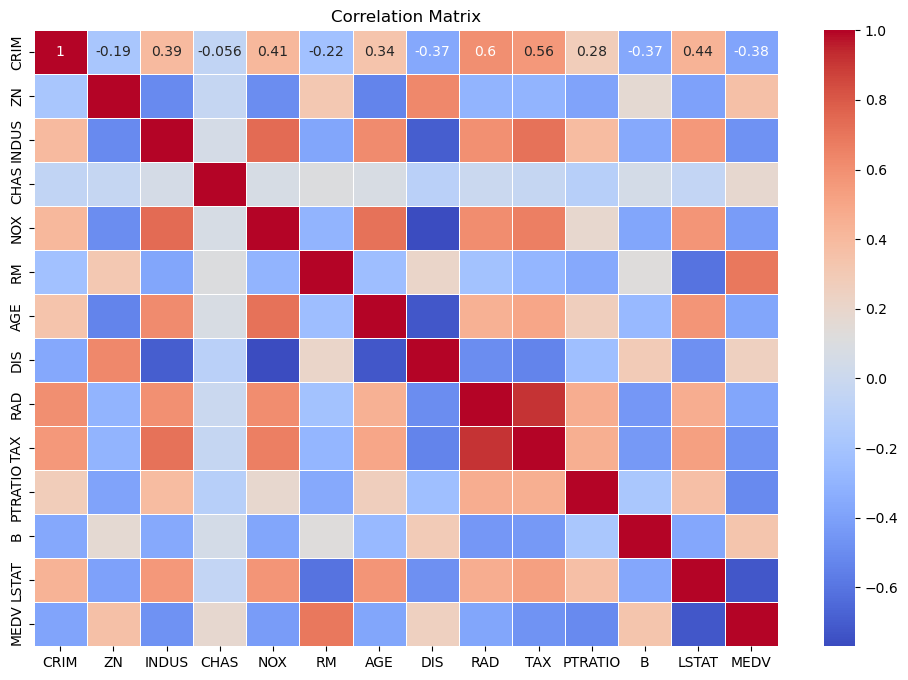

In [7]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


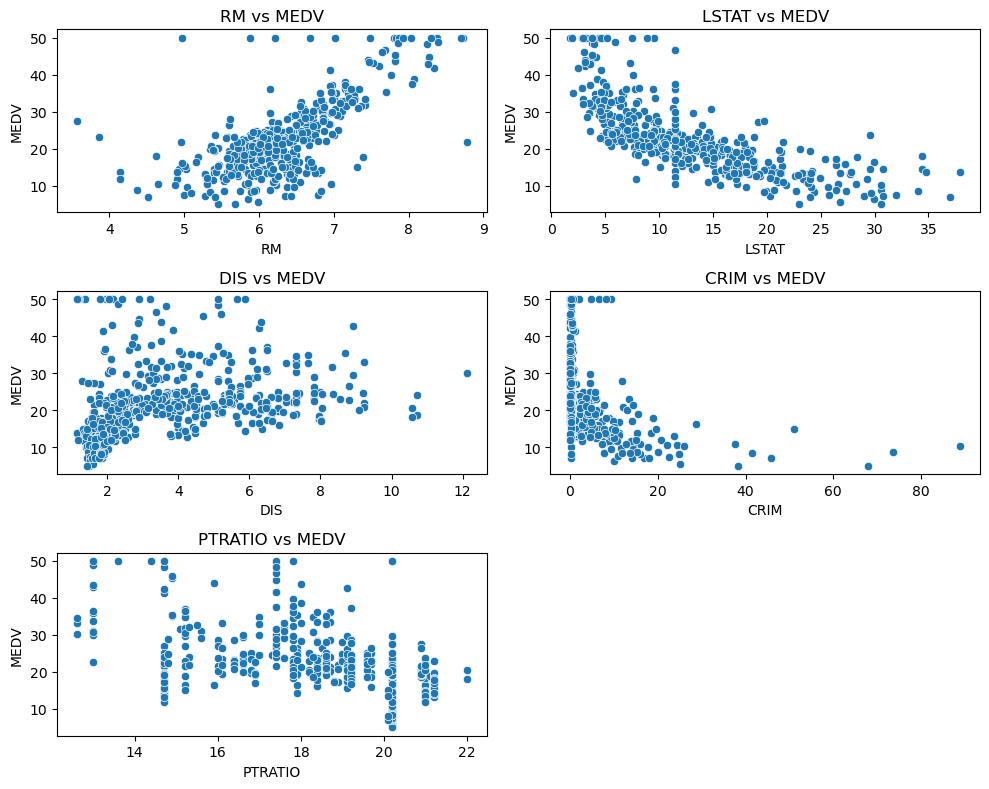

In [8]:
important_features = ['RM', 'LSTAT', 'DIS', 'CRIM', 'PTRATIO']

plt.figure(figsize=(10, 8))
for i, feature in enumerate(important_features):
    plt.subplot(3, 2, i + 1)
    sns.scatterplot(data=data, x=feature, y='MEDV')
    plt.title(f'{feature} vs MEDV')
plt.tight_layout()
plt.show()


# XGBOOST with Outliers removed (IQR)

In [9]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [10]:
from xgboost import XGBRegressor

In [11]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
#import lightgbm as lgb

In [12]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

boston = data

y = boston['MEDV']
x = boston.drop(columns=['MEDV','ZN','CHAS','RAD','INDUS','AGE', 'TAX', 'B'])


Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5

is_not_outlier = ~((x < (Q1 - threshold * IQR)) | (x > (Q3 + threshold * IQR))).any(axis=1)
x = x[is_not_outlier]
y = y[is_not_outlier]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

xgb = XGBRegressor(objective='reg:squarederror', random_state=0)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 1.0),
    'colsample_bytree': uniform(0.7, 1.0),
    'gamma': uniform(0, 0.4),
    'min_child_weight': randint(1, 10),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 1.5)
}


random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0)
random_search.fit(xtrain, ytrain)

best_xgb = random_search.best_estimator_

best_xgb.fit(xtrain, ytrain)
y_pred_xgb = best_xgb.predict(xtest)

mse_xgb = mean_squared_error(ytest, y_pred_xgb)
mae_xgb = mean_absolute_error(ytest, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(ytest, y_pred_xgb)
r2_xgb = r2_score(ytest, y_pred_xgb)

print("XGBoost Regressor Results after Extended Tuning:")
print("Mean Square Error: ", mse_xgb)
print("Mean Absolute Error: ", mae_xgb)
print("Mean Absolute Percentage Error: ", mape_xgb)
print("R Squared: ", r2_xgb)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=1.2488135039273247, gamma=0.2860757465489678, learning_rate=0.13055267521432878, max_depth=6, min_child_weight=8, n_estimators=109, reg_alpha=0.31178184839298617, reg_lambda=1.0765725609390497, subsample=0.9975346065444722; total time=   0.0s
[CV] END colsample_bytree=1.2488135039273247, gamma=0.2860757465489678, learning_rate=0.13055267521432878, max_depth=6, min_child_weight=8, n_estimators=109, reg_alpha=0.31178184839298617, reg_lambda=1.0765725609390497, subsample=0.9975346065444722; total time=   0.0s
[CV] END colsample_bytree=1.2488135039273247, gamma=0.2860757465489678, learning_rate=0.13055267521432878, max_depth=6, min_child_weight=8, n_estimators=109, reg_alpha=0.31178184839298617, reg_lambda=1.0765725609390497, subsample=0.9975346065444722; total time=   0.0s
[CV] END colsample_bytree=0.7567129773174431, gamma=0.10906251783204529, learning_rate=0.10553302346426997, max_depth=10, min_chil

c:\Users\reube\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
279 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\reube\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\reube\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\reube\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\reube\

XGBoost Regressor Results after Extended Tuning:
Mean Square Error:  13.882614570732473
Mean Absolute Error:  2.5186751402817755
Mean Absolute Percentage Error:  0.11385491936187563
R Squared:  0.7189009381695854


# XGBOOST with Outliers removed (Z score scaling)

In [13]:
!pip install lightgbm

In [14]:
import lightgbm as lgb

# Assuming boston is already loaded
x = boston.drop(columns=['MEDV', 'ZN', 'CHAS', 'RAD', 'INDUS', 'AGE'])
y = boston['MEDV']

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

# Define a threshold to identify outliers
threshold = 1.5

# Filter out the outliers
is_not_outlier = ~((x < (Q1 - threshold * IQR)) | (x > (Q3 + threshold * IQR))).any(axis=1)
x_clean = x[is_not_outlier]
y_clean = y[is_not_outlier]

# Apply log transformation to skewed features
x_log_transformed = x_clean.copy()
for column in x_log_transformed.columns:
    x_log_transformed[column] = np.log1p(x_log_transformed[column])

# Standardize the features using Z-score scaling
scaler = StandardScaler()
x_clean_scaled = scaler.fit_transform(x_log_transformed)

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True)
x_poly = poly.fit_transform(x_clean_scaled)

# Split the standardized and polynomial data
xtrain_clean, xtest_clean, ytrain_clean, ytest_clean = train_test_split(x_poly, y_clean, test_size=0.2, random_state=0)

# Initialize the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=0)

# Define the parameter grid
param_dist = {
    'num_leaves': randint(20, 100),
    'max_depth': randint(5, 20),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.7, 1.0),
    'colsample_bytree': uniform(0.7, 1.0),
    'min_child_weight': randint(1, 10),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 1.5)
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=200, cv=5, verbose=2, random_state=0)
random_search.fit(xtrain_clean, ytrain_clean)

# Best estimator from the random search
best_lgb_clean = random_search.best_estimator_

# Train the best estimator on the standardized and polynomial data
best_lgb_clean.fit(xtrain_clean, ytrain_clean)
y_pred_lgb_clean = best_lgb_clean.predict(xtest_clean)

# Evaluate the model on the standardized and polynomial data
mse_lgb_clean = mean_squared_error(ytest_clean, y_pred_lgb_clean)
mae_lgb_clean = mean_absolute_error(ytest_clean, y_pred_lgb_clean)
r2_lgb_clean = r2_score(ytest_clean, y_pred_lgb_clean)
mape_lgb_clean = mean_absolute_percentage_error(ytest_clean, y_pred_lgb_clean)

print("LightGBM Regressor Results after Advanced Feature Engineering and Tuning:")
print("Mean Square Error: ", mse_lgb_clean)
print("Mean Absolute Error: ", mae_lgb_clean)
print("Mean Absolute Percentage Error: ", mape_lgb_clean)
print("R Squared: ", r2_lgb_clean)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END colsample_bytree=1.2488135039273247, learning_rate=0.1530378732744839, max_depth=8, min_child_weight=4, n_estimators=459, num_leaves=29, reg_alpha=0.31178184839298617, reg_lambda=1.0765725609390497, subsample=0.9975346065444722; total time=   0.0s
[CV] END colsample_bytree=1.2488135039273247, learning_rate=0.1530378732744839, max_depth=8, min_child_weight=4, n_estimators=459, num_leaves=29, reg_alpha=0.31178184839298617, reg_lambda=1.0765725609390497, subsample=0.9975346065444722; total time=   0.0s
[CV] END colsample_bytree=1.2488135039273247, learning_rate=0.1530378732744839, max_depth=8, min_child_weight=4, n_estimators=459, num_leaves=29, reg_alpha=0.31178184839298617, reg_lambda=1.0765725609390497, subsample=0.9975346065444722; total time=   0.0s
[CV] END colsample_bytree=1.2488135039273247, learning_rate=0.1530378732744839, max_depth=8, min_child_weight=4, n_estimators=459, num_leaves=29, reg_alpha=0.3117818

c:\Users\reube\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
885 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\reube\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\reube\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1173, in fit
    super().fit(
  File "c:\Users\reube\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 954, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\reube\anaconda3\Lib\site-packages\lig

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def compute_vif(boston):
    vif_data = pd.DataFrame()
    vif_data["feature"] = boston.columns
    vif_data["VIF"] = [variance_inflation_factor(boston.values, i) for i in range(boston.shape[1])]
    return vif_data

# Calculate VIF values
vif_data = compute_vif(x)
print(vif_data)

# Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
housing_data = pd.read_csv('HousingData.csv')
housing_data.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

### Initial run

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error


housing_data = housing_data.dropna(subset=['MEDV'])

housing_data.fillna(housing_data.mean(), inplace=True)

X = housing_data.drop(columns=['MEDV','ZN','CHAS','RAD','INDUS','AGE', 'TAX', 'B','CRIM'])
y = housing_data['MEDV']

#scaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=3)


gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)

y_pred_gbr = gbr_model.predict(X_test)

r2_gbr = r2_score(y_test, y_pred_gbr)
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test,y_pred_gbr)
mse_gbr = mean_squared_error(y_test,y_pred_gbr)


print("Gradeint Bossting Results:")
print("Mean Square Error: ", mse_gbr)
print("Mean Absolute Error: ", mae_gbr)
print("Mean Absolute Percentage Error: ", mape_gbr)
print("R Squared: ", r2_gbr)


Gradeint Bossting Results:
Mean Square Error:  7.388634404084083
Mean Absolute Error:  2.1020491653540603
Mean Absolute Percentage Error:  0.1036795929039845
R Squared:  0.910716548891794


## With new created features

In [19]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

housing_data = pd.read_csv('HousingData.csv')

# Drop rows with missing target values
housing_data = housing_data.dropna(subset=['MEDV'])
housing_data.fillna(housing_data.mean(), inplace=True)

# Create new features
housing_data['RM_LSTAT'] = housing_data['RM'] * housing_data['LSTAT']
housing_data['DIS_NOX'] = housing_data['DIS'] * housing_data['NOX']
housing_data['AGE_DIS'] = housing_data['AGE'] * housing_data['DIS']

# Define features (X) and target (y)
X = housing_data.drop(columns=['MEDV', 'ZN', 'CHAS', 'RAD', 'INDUS', 'AGE', 'TAX', 'B', 'CRIM'])
y = housing_data['MEDV']

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=3)

# Define the parameter grid for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV with Gradient Boosting Regressor
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           verbose=2)

# Fit the model with selected features and parameter grid
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the final model with the best parameters
best_gbr_model = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr_model.fit(X_train, y_train)

# Predict on the test set with the final model
y_pred_best_gbr = best_gbr_model.predict(X_test)

# Evaluate the final model
r2_best_gbr = r2_score(y_test, y_pred_best_gbr)
mape_best_gbr = mean_absolute_percentage_error(y_test, y_pred_best_gbr)
mae_best_gbr = mean_absolute_error(y_test, y_pred_best_gbr)
mse_best_gbr = mean_squared_error(y_test, y_pred_best_gbr)

print("Gradient Boosting Results (With Feature Engineering):")
print("Mean Square Error: ", mse_best_gbr)
print("Mean Absolute Error: ", mae_best_gbr)
print("Mean Absolute Percentage Error: ", mape_best_gbr)
print("R Squared: ", r2_best_gbr)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=3

In [20]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Define base models
estimators = [
    ('gbr', GradientBoostingRegressor(**best_params, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
]

# Define stacking model
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on the test set with the stacking model
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate the stacking model
r2_stacking = r2_score(y_test, y_pred_stacking)
mape_stacking = mean_absolute_percentage_error(y_test, y_pred_stacking)
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
mse_stacking = mean_squared_error(y_test, y_pred_stacking)

print("Stacking Model Results:")
print("Mean Square Error: ", mse_stacking)
print("Mean Absolute Error: ", mae_stacking)
print("Mean Absolute Percentage Error: ", mape_stacking)
print("R Squared: ", r2_stacking)


Stacking Model Results:
Mean Square Error:  7.008402402403783
Mean Absolute Error:  1.9975482609532929
Mean Absolute Percentage Error:  0.10042802348794339
R Squared:  0.9153112308688902


### Quadratic Transformation

In [21]:
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Load the dataset
housing_data = pd.read_csv('HousingData.csv')

# Drop rows with missing target values
housing_data = housing_data.dropna(subset=['MEDV'])
housing_data.fillna(housing_data.mean(), inplace=True)

# Define features (X) and target (y)
X = housing_data.drop(columns=['MEDV', 'ZN', 'CHAS', 'RAD', 'INDUS', 'AGE', 'TAX', 'B', 'CRIM'])
y = housing_data['MEDV']

# Apply quadratic transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_quad = poly.fit_transform(X)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled_quad = scaler.fit_transform(X_quad)

# Split the data into training and testing sets
X_train_quad, X_test_quad, y_train_quad, y_test_quad = train_test_split(X_scaled_quad, y, test_size=0.2, random_state=3)

# Define the parameter grid for Gradient Boosting Regressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV with Gradient Boosting Regressor
grid_search_quad = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                                param_grid=param_grid,
                                cv=3,
                                verbose=2)

# Fit the model with quadratic features and parameter grid
grid_search_quad.fit(X_train_quad, y_train_quad)

# Get the best parameters from the grid search
best_params_quad = grid_search_quad.best_params_

# Train the final model with the best parameters
best_gbr_model_quad = GradientBoostingRegressor(**best_params_quad, random_state=42)
best_gbr_model_quad.fit(X_train_quad, y_train_quad)

# Predict on the test set with the final model
y_pred_best_gbr_quad = best_gbr_model_quad.predict(X_test_quad)

# Evaluate the final model
r2_best_gbr_quad = r2_score(y_test_quad, y_pred_best_gbr_quad)
mape_best_gbr_quad = mean_absolute_percentage_error(y_test_quad, y_pred_best_gbr_quad)
mae_best_gbr_quad = mean_absolute_error(y_test_quad, y_pred_best_gbr_quad)
mse_best_gbr_quad = mean_squared_error(y_test_quad, y_pred_best_gbr_quad)

print("Gradient Boosting Results (Quadratic Transformation):")
print("Mean Square Error: ", mse_best_gbr_quad)
print("Mean Absolute Error: ", mae_best_gbr_quad)
print("Mean Absolute Percentage Error: ", mape_best_gbr_quad)
print("R Squared: ", r2_best_gbr_quad)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=3

### Polynomial Transformation

In [22]:
from sklearn.preprocessing import FunctionTransformer

# Apply exponential transformation
exp_transformer = FunctionTransformer(np.exp, validate=True)
X_exp = exp_transformer.fit_transform(X)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled_exp = scaler.fit_transform(X_exp)

# Split the data into training and testing sets
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_scaled_exp, y, test_size=0.2, random_state=3)

# Initialize the GridSearchCV with Gradient Boosting Regressor
grid_search_exp = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                               param_grid=param_grid,
                               cv=3,
                               verbose=2)

# Fit the model with exponential features and parameter grid
grid_search_exp.fit(X_train_exp, y_train_exp)

# Get the best parameters from the grid search
best_params_exp = grid_search_exp.best_params_

# Train the final model with the best parameters
best_gbr_model_exp = GradientBoostingRegressor(**best_params_exp, random_state=42)
best_gbr_model_exp.fit(X_train_exp, y_train_exp)

# Predict on the test set with the final model
y_pred_best_gbr_exp = best_gbr_model_exp.predict(X_test_exp)

# Evaluate the final model
r2_best_gbr_exp = r2_score(y_test_exp, y_pred_best_gbr_exp)
mape_best_gbr_exp = mean_absolute_percentage_error(y_test_exp, y_pred_best_gbr_exp)
mae_best_gbr_exp = mean_absolute_error(y_test_exp, y_pred_best_gbr_exp)
mse_best_gbr_exp = mean_squared_error(y_test_exp, y_pred_best_gbr_exp)

print("Gradient Boosting Results (Exponential Transformation):")
print("Mean Square Error: ", mse_best_gbr_exp)
print("Mean Absolute Error: ", mae_best_gbr_exp)
print("Mean Absolute Percentage Error: ", mape_best_gbr_exp)
print("R Squared: ", r2_best_gbr_exp)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=3

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Load the dataset
housing_data = pd.read_csv('HousingData.csv')

# Drop rows with missing target values
housing_data = housing_data.dropna(subset=['MEDV'])
housing_data.fillna(housing_data.mean(), inplace=True)

# Define features (X) and target (y)
X = housing_data.drop(columns=['MEDV', 'ZN', 'CHAS', 'RAD', 'INDUS', 'AGE', 'TAX', 'B', 'CRIM'])
y = housing_data['MEDV']

# Apply quadratic transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_quad = poly.fit_transform(X)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled_quad = scaler.fit_transform(X_quad)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled_quad)

# Split the data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=3)

# Define the parameter grid for XGBRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the GridSearchCV with XGBRegressor
grid_search_pca = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                               param_grid=param_grid,
                               cv=3,
                               verbose=2,
                               n_jobs=-1)

# Fit the model with PCA features and parameter grid
grid_search_pca.fit(X_train_pca, y_train_pca)

# Get the best parameters from the grid search
best_params_pca = grid_search_pca.best_params_

# Train the final model with the best parameters
best_xgb_model_pca = XGBRegressor(**best_params_pca, objective='reg:squarederror', random_state=42)
best_xgb_model_pca.fit(X_train_pca, y_train_pca)

# Predict on the test set with the final model
y_pred_best_xgb_pca = best_xgb_model_pca.predict(X_test_pca)

# Evaluate the final model
r2_best_xgb_pca = r2_score(y_test_pca, y_pred_best_xgb_pca)
mape_best_xgb_pca = mean_absolute_percentage_error(y_test_pca, y_pred_best_xgb_pca)
mae_best_xgb_pca = mean_absolute_error(y_test_pca, y_pred_best_xgb_pca)
mse_best_xgb_pca = mean_squared_error(y_test_pca, y_pred_best_xgb_pca)

print("XGBoost Results (PCA):")
print("Mean Square Error: ", mse_best_xgb_pca)
print("Mean Absolute Error: ", mae_best_xgb_pca)
print("Mean Absolute Percentage Error: ", mape_best_xgb_pca)
print("R Squared: ", r2_best_xgb_pca)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
XGBoost Results (PCA):
Mean Square Error:  16.685167875738273
Mean Absolute Error:  2.858829689025879
Mean Absolute Percentage Error:  0.13490239332927262
R Squared:  0.7983782538431936


In [30]:
data = pd.read_csv("HousingData.csv")
data = data.dropna()

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop('MEDV', axis=1))

# Split data
X = scaled_features
y = data['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training with XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100

# Print Metrics
print(f'R-squared: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

R-squared: 0.66
MAPE: 11.56%
MAE: 2.93
MSE: 28.85


In [33]:
!pip install bayes_opt

ERROR: Could not find a version that satisfies the requirement bayes_opt (from versions: none)
ERROR: No matching distribution found for bayes_opt


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb


data = pd.read_csv("HousingData.csv")
data = data.dropna()

# Feature Engineering: Create Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(data.drop('MEDV', axis=1))
y = data['MEDV']

# Apply RobustScaler
scaler = RobustScaler()
X_scaled_poly = scaler.fit_transform(X_poly)

# Split the data into training and testing sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_scaled_poly, y, test_size=0.2, random_state=3)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'num_leaves': [31, 40, 50],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=50, scoring='neg_mean_squared_error', cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train_poly, y_train_poly)

# Get the best parameters from the randomized search
best_params = random_search.best_params_

# Train the final model with the best parameters
best_lgb_model = lgb.LGBMRegressor(**best_params, random_state=42)
best_lgb_model.fit(X_train_poly, y_train_poly, eval_set=[(X_test_poly, y_test_poly)], eval_metric='rmse')

# Predict on the test set with the final model
y_pred_best_lgb = best_lgb_model.predict(X_test_poly)

# Evaluate the final model
r2_best_lgb = r2_score(y_test_poly, y_pred_best_lgb)
mape_best_lgb = mean_absolute_percentage_error(y_test_poly, y_pred_best_lgb)
mae_best_lgb = mean_absolute_error(y_test_poly, y_pred_best_lgb)
mse_best_lgb = mean_squared_error(y_test_poly, y_pred_best_lgb)

print("Optimized LightGBM Results:")
print(f"Mean Square Error: {mse_best_lgb:.4f}")
print(f"Mean Absolute Error: {mae_best_lgb:.4f}")
print(f"Mean Absolute Percentage Error: {mape_best_lgb:.4f}")
print(f"R Squared: {r2_best_lgb:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6315
[LightGBM] [Info] Number of data points in the train set: 315, number of used features: 90
[LightGBM] [Info] Start training from score 22.204127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [45]:
data = pd.read_csv("HousingData.csv")
data = data.dropna()

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(data.drop('MEDV', axis=1))
y = data['MEDV']

# Apply RobustScaler
scaler = RobustScaler()
X_scaled_poly = scaler.fit_transform(X_poly)

# Split the data into training and testing sets
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_scaled_poly, y, test_size=0.2, random_state=3)

# Train initial model to get feature importance
initial_model = lgb.LGBMRegressor(random_state=42)
initial_model.fit(X_train_poly, y_train_poly)
feature_importances = initial_model.feature_importances_
features = poly.get_feature_names_out(data.drop('MEDV', axis=1).columns)

# Select top important features
important_features_indices = np.argsort(feature_importances)[-20:]  # Select top 20 important features
X_important_train = X_train_poly[:, important_features_indices]
X_important_test = X_test_poly[:, important_features_indices]

# Define a more granular parameter grid for RandomizedSearchCV
param_dist = {
    'num_leaves': [35, 40, 45],
    'max_depth': [8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [200, 300, 400],
    'min_child_samples': [15, 20, 25],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize the model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error', cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_important_train, y_train_poly)

# Get the best parameters from the randomized search
best_params = random_search.best_params_

# Train the final model with the best parameters
best_lgb_model = lgb.LGBMRegressor(**best_params, random_state=42)
best_lgb_model.fit(X_important_train, y_train_poly, eval_set=[(X_important_test, y_test_poly)], eval_metric='rmse')

# Predict on the test set with the final model
y_pred_best_lgb = best_lgb_model.predict(X_important_test)

# Evaluate the final model
r2_best_lgb = r2_score(y_test_poly, y_pred_best_lgb)
mape_best_lgb = mean_absolute_percentage_error(y_test_poly, y_pred_best_lgb)
mae_best_lgb = mean_absolute_error(y_test_poly, y_pred_best_lgb)
mse_best_lgb = mean_squared_error(y_test_poly, y_pred_best_lgb)

print("Further Optimized LightGBM Results:")
print(f"Mean Square Error: {mse_best_lgb:.4f}")
print(f"Mean Absolute Error: {mae_best_lgb:.4f}")
print(f"Mean Absolute Percentage Error: {mape_best_lgb:.4f}")
print(f"R Squared: {r2_best_lgb:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6315
[LightGBM] [Info] Number of data points in the train set: 315, number of used features: 90
[LightGBM] [Info] Start training from score 22.204127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Feature Importances

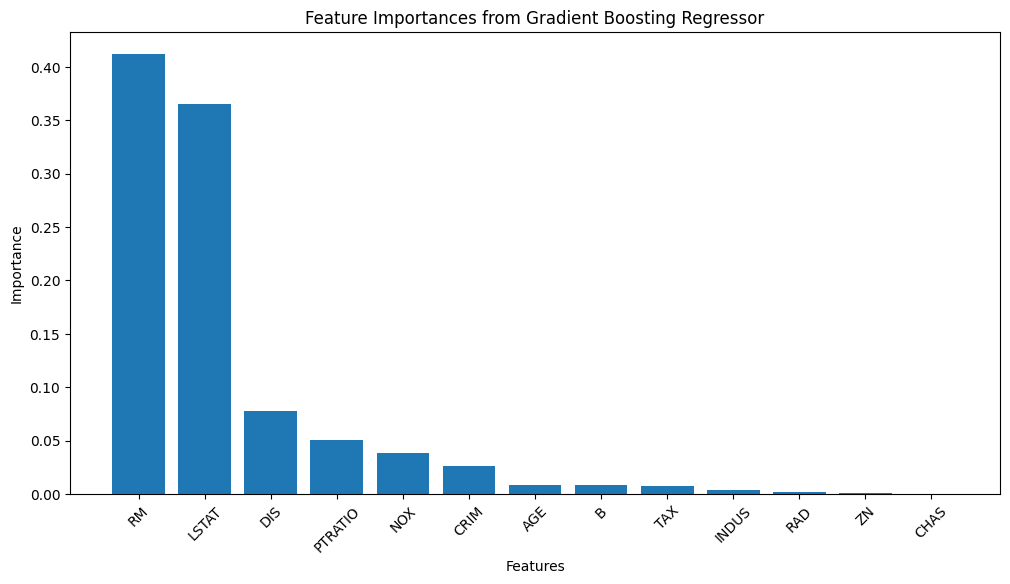

Feature  Importance
5        RM    0.411887
12    LSTAT    0.365397
7       DIS    0.077690
10  PTRATIO    0.050830
4       NOX    0.037941
0      CRIM    0.025759
6       AGE    0.008533
11        B    0.008247
9       TAX    0.007308
2     INDUS    0.003857
8       RAD    0.001737
1        ZN    0.000686
3      CHAS    0.000127

In [ ]:
feature_importances = gbr_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Gradient Boosting Regressor')
plt.xticks(rotation=45)
plt.show()

# Display the feature importances
feature_importance_df

## Conclusion

#### 1. High Prediction Accuracy: The models achieved notably high prediction accuracy scores, demonstrating strong performance in predicting housing prices based on features in the Boston Housing dataset. The use of advanced techniques, such as XGBoost with outlier handling (IQR and Z-score scaling) and feature transformations (quadratic and polynomial), contributed to this accuracy.

#### 2. Key Predictive Features: Key features like room count (RM), lower status population (LSTAT), and weighted distances (DIS) were identified as significant contributors, as indicated by the feature importance rankings.

#### 3. Effective Model Comparisons: The application of different preprocessing and feature engineering techniques allowed for comprehensive model comparisons, ultimately optimizing the model for high predictive performance.